# Setup

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ESA-Datalabs/XAMI-model/blob/main/dataset_and_model.ipynb)

In [1]:
import sys
import os

if 'google.colab' in sys.modules:
    !pip install -q condacolab
    import condacolab
    condacolab.install()

In [ ]:
# skip this step if the package already exists
!git clone https://github.com/ESA-Datalabs/XAMI-model.git
os.chdir("XAMI-model")
!conda env update -n base -f environment.yaml
!pip install -e .

## Download dataset

In [ ]:
!git clone https://github.com/ESA-Datalabs/XAMI-dataset.git
!pip install -e XAMI-dataset/

In [ ]:
# in colab, there is an issue with recognizing these packages 
if 'google.colab' in sys.modules: 
  sys.path.append(os.getcwd())
  sys.path.append(os.path.join(os.getcwd(), 'XAMI-dataset'))

In [2]:
from xami_dataset.loader import XAMIDataset

# Download the dataset
xami_dataset = XAMIDataset(
    repo_id="iulia-elisa/XAMI-dataset",
    dataset_name="xami_dataset", # this is the COCO format of the dataset (can use 'xami_dataset_yolov8' for the yolov8 format)
    dest_dir='./data')

xami_dataset.zip:   0%|          | 0.00/50.8M [00:00<?, ?B/s]

Dataset downloaded.
Dataset unzipped.
Train annotations file: ./data_2/xami_dataset/train/_annotations.coco.json
Valid annotations file: ./data_2/xami_dataset/valid/_annotations.coco.json


## Download model weights

In [12]:
from huggingface_hub import hf_hub_download

dest_dir = './xami_model/train/weights_2/'

# the RT-DETR backbone performs better than YOLO (except on 'Other' class)
# YOLOv8n is faster and has a good speed-accuracy trade-off, with usually -10ms on inference compared to RT-DETR

det_type = 'yolov8' # 'yolov8' or 'rtdetr'

checkpoints = [
        f'{det_type}_sam_weights/{det_type}_detect_300e_best.pt', 
        f'{det_type}_sam_weights/{det_type}_sam.pth']

# download checkpoints from HuggingFace
for checkpoint in checkpoints:
    hf_hub_download(
    			repo_id="iulia-elisa/XAMI-model",
    			repo_type='model',
    			filename=checkpoint,
    			local_dir=dest_dir
    		)
print(f'Checkpoints saved in {dest_dir}')

yolov8_detect_300e_last.pt:   0%|          | 0.00/6.81M [00:00<?, ?B/s]

Checkpoints saved in ./xami_model/train/weights_2/


# Inference

In [16]:
from xami_model.inference.xami_inference import InferXami

detr_checkpoint = f'./xami_model/train/weights_2/{det_type}_sam_weights/{det_type}_detect_300e_best.pt'
sam_checkpoint = f'./xami_model/train/weights_2/{det_type}_sam_weights/{det_type}_sam.pth'

#❗️the SAM checkpoint and model_type (vit_h, vit_t, etc.) must be compatible
#❗️the detr_type and its checkpoints must be compatible
detr_sam_pipeline = InferXami(
    device='cuda:0',
    detr_checkpoint=detr_checkpoint,
    sam_checkpoint=sam_checkpoint,
    model_type='vit_t',
    use_detr_masks=True,
    detr_type=det_type) # 'rtdetr' or 'yolo[v8]' variants

Initializing the model...
Using YOLO masks for faint (1sigma) sources.


Warming up SAM model: 100%|██████████| 3/3 [00:00<00:00, 21.68it/s]                                                                  


Number of object detected: 2
   central-ring
   star-loop


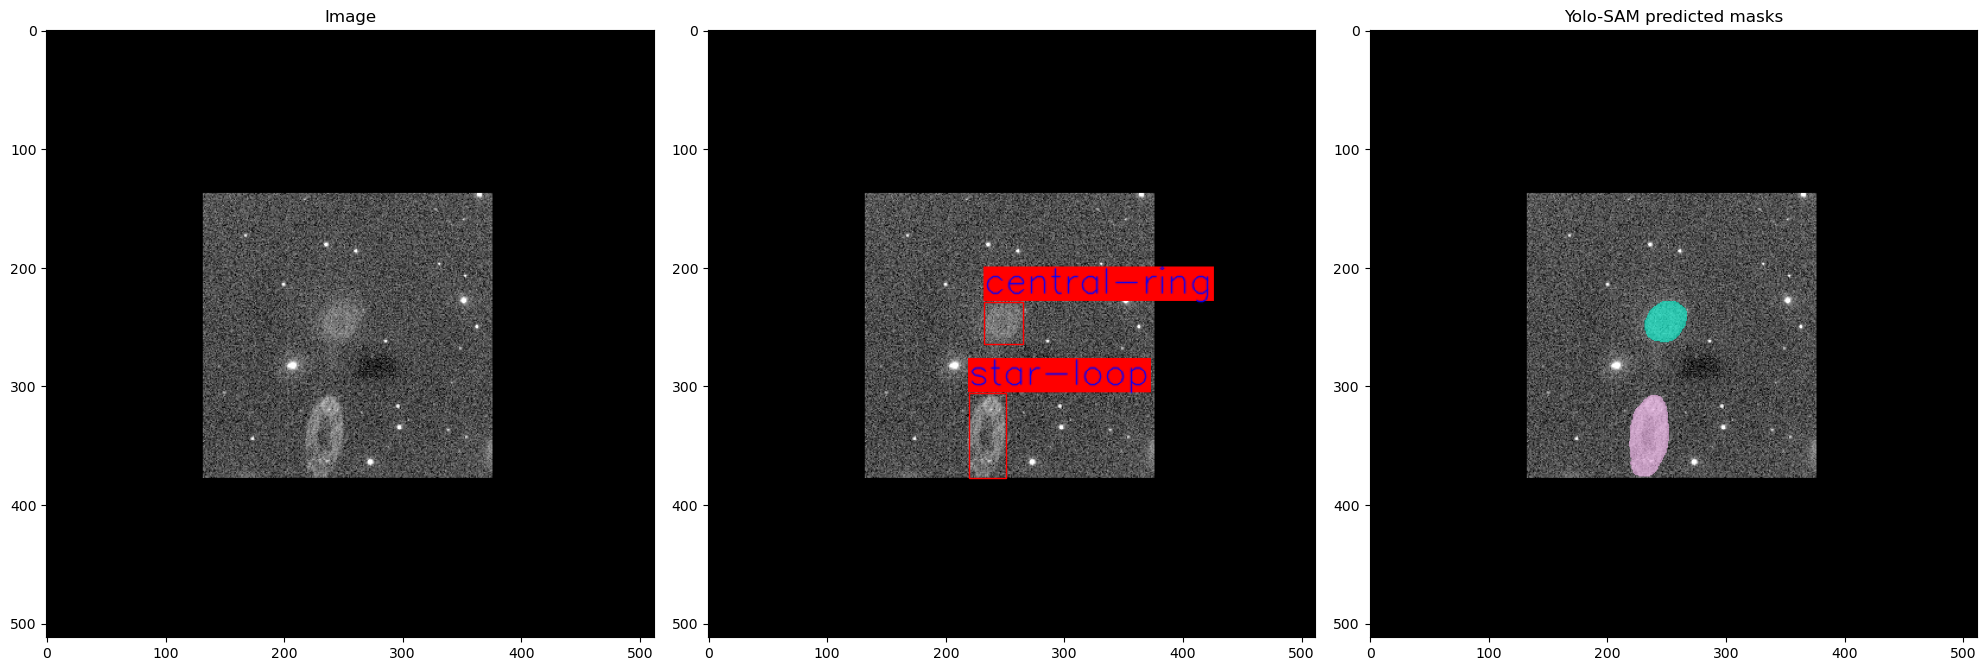

In [17]:
masks = detr_sam_pipeline.run_predict('./example_images/S0893811101_M.png', show_masks=True)

Number of object detected: 2
   star-loop


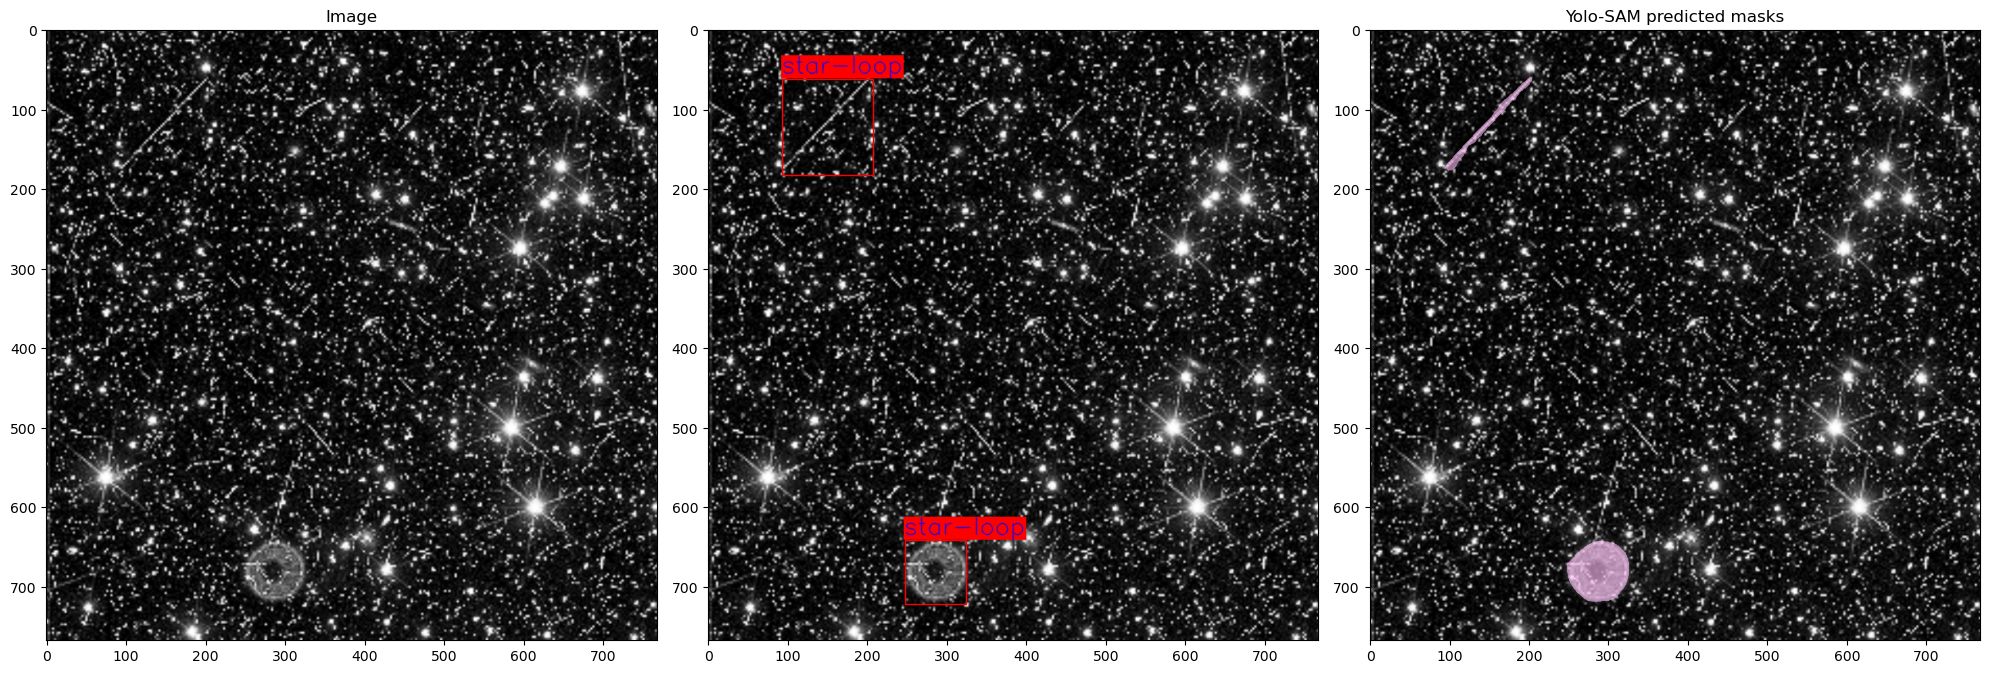

In [19]:
masks = detr_sam_pipeline.run_predict('./example_images/euclid_artefacts.png', show_masks=True)